# 1. Analysis
Data Loading, Cleaning, and Sampling Approach.

In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, _tree
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random

# --- REPRODUCIBILITY SEED ---
# As requested, defined in Section 1 (Analysis) for global usage.
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# --- DATA CLEANING ---
df_raw = pd.read_excel('academicPerformanceData.xlsx', header=None)
header_idx = None
for i, row in df_raw.head(50).iterrows():
    row_str = row.astype(str).str.lower().to_list()
    if 'remarks' in row_str or 'x7' in row_str:
        header_idx = i
        break
if header_idx is None: header_idx = 0
    
df = pd.read_excel('academicPerformanceData.xlsx', header=header_idx)
df.columns = df.columns.astype(str).str.strip().str.lower()
expected_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'remarks']
cols_to_keep = [c for c in expected_cols if c in df.columns]
df = df[cols_to_keep]
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['remarks'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Data Loaded. Cleaning Complete.")

Data Loaded. Cleaning Complete.


# 2. FIS
Implementations for Mamdani and Improved FIS.

## 2a. Mamdani FIS
Manual rule derivation and implementation.

In [2]:
def create_manual_fis_patterns():
    # --- HEURISTIC: Calculate approximate class centers for MF alignment ---
    # We do this for the whole dataset to get "Expert Knowledge"
    class_stats = df.groupby('remarks').mean()
    
    # 1. Define Antecedents & Consequent
    x1 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x1')
    x2 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x2')
    x3 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x3')
    x4 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x4')
    x5 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x5')
    x6 = ctrl.Antecedent(np.arange(0, 11, 0.1), 'x6')
    x7 = ctrl.Antecedent(np.arange(0, 41, 0.1), 'x7')
    remarks = ctrl.Consequent(np.arange(1, 6, 0.1), 'remarks')
    
    def add_statistical_mfs(var, feature_name):
        # Map class means to linguistic terms
        means = class_stats[feature_name].sort_values()
        # Ensure we have 5 buckets (or 3 for simpler ones)
        # We'll use 5 for x7 and 3 for others
        if feature_name == 'x7':
            var['very_low'] = fuzz.trapmf(var.universe, [0, 0, means.iloc[0], means.iloc[1]])
            var['low'] = fuzz.trapmf(var.universe, [means.iloc[0], means.iloc[1], means.iloc[1], means.iloc[2]])
            var['medium'] = fuzz.trapmf(var.universe, [means.iloc[1], means.iloc[2], means.iloc[2], means.iloc[3]])
            var['high'] = fuzz.trapmf(var.universe, [means.iloc[2], means.iloc[3], means.iloc[3], means.iloc[4]])
            var['very_high'] = fuzz.trapmf(var.universe, [means.iloc[3], means.iloc[4], 40, 40])
        else:
            var['low'] = fuzz.trapmf(var.universe, [0, 0, means.iloc[0], means.iloc[2]])
            var['medium'] = fuzz.trapmf(var.universe, [means.iloc[0], means.iloc[2], means.iloc[2], means.iloc[4]])
            var['high'] = fuzz.trapmf(var.universe, [means.iloc[2], means.iloc[4], 10, 10])

    for v, name in zip([x1, x2, x3, x4, x5, x6, x7], ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']):
        add_statistical_mfs(v, name)

    remarks['poor'] = fuzz.trimf(remarks.universe, [1, 1, 2])
    remarks['below_average'] = fuzz.trimf(remarks.universe, [1, 2, 3])
    remarks['average'] = fuzz.trimf(remarks.universe, [2, 3, 4])
    remarks['good'] = fuzz.trimf(remarks.universe, [3, 4, 5])
    remarks['excellent'] = fuzz.trimf(remarks.universe, [4, 5, 5])
    
    # 3. Rules (Informed Manual Rules)
    rules = []
    # Primary Authority: x7 (the most dominant feature)
    rules.append(ctrl.Rule(x7['very_low'], remarks['poor']))
    rules.append(ctrl.Rule(x7['low'], remarks['below_average']))
    rules.append(ctrl.Rule(x7['medium'], remarks['average']))
    rules.append(ctrl.Rule(x7['high'], remarks['good']))
    rules.append(ctrl.Rule(x7['very_high'], remarks['excellent']))
    
    # Secondary Interactions: Support from other variables
    # If attendance (x1) and engagement (x6) are high, push the grade up
    rules.append(ctrl.Rule(x1['high'] & x6['high'] & x7['medium'], remarks['good']))
    rules.append(ctrl.Rule(x1['low'] & x6['low'] & x7['medium'], remarks['below_average']))
    
    # Combine with some balanced rules
    rules.append(ctrl.Rule(x2['high'] & x3['high'] & x7['high'], remarks['excellent']))
    rules.append(ctrl.Rule(x4['low'] & x5['low'] & x7['low'], remarks['poor']))

    # --- NEW RULES (Targeting 10-20 range) ---
    # 10. "The Savior": High Coursework (x2, x3) saves a Low Exam
    rules.append(ctrl.Rule(x2['high'] & x3['high'] & x7['low'], remarks['average']))

    # 11. "The Anchor": Low Participation (x1) and Quizzes (x2) drag down Medium Exam
    rules.append(ctrl.Rule(x1['low'] & x2['low'] & x7['medium'], remarks['below_average']))

    # 12. "Solid Performer": Consistent Medium across board
    rules.append(ctrl.Rule(x2['medium'] & x3['medium'] & x5['medium'] & x7['medium'], remarks['average']))

    # 13. "Potential Star": High x4 (Midterm?) and x5 (Project?) boosting High Exam
    rules.append(ctrl.Rule(x4['high'] & x5['high'] & x7['high'], remarks['excellent']))

    # 14. "Struggling": Low x1, x2, x3 reinforcing Low Exam
    rules.append(ctrl.Rule(x1['low'] & x3['low'] & x7['low'], remarks['poor']))

    # 15. "Recovering": High x6 (Participation) helping a Very Low exam slightly
    rules.append(ctrl.Rule(x6['high'] & x7['very_low'], remarks['poor'])) # Still poor, but maybe higher val? Keep poor for safety.

    # 16. "Borderline pass": all medium except x7 low
    rules.append(ctrl.Rule(x1['medium'] & x2['medium'] & x3['medium'] & x4['medium'] & x7['low'], remarks['below_average']))
    
    print(f"Loaded {len(rules)} Enhanced Heuristic Rules.")
    fis_ctrl = ctrl.ControlSystem(rules)
    return ctrl.ControlSystemSimulation(fis_ctrl), x1, x2, x3, x4, x5, x6, x7, remarks

manual_sim, mx1, mx2, mx3, mx4, mx5, mx6, mx7, mremarks = create_manual_fis_patterns()

def get_fis_preds(sim, data):
    preds = []
    for _, row in data.iterrows():
        try:
            for col in ['x1','x2','x3','x4','x5','x6','x7']:
                if col in row: sim.input[col] = row[col]
            sim.compute()
            preds.append(round(sim.output['remarks']))
        except:
            preds.append(3)
    return preds
print("Manual FIS Initialized.")

Loaded 16 Enhanced Heuristic Rules.
Manual FIS Initialized.


## 2b. Improved FIS
Dynamic Rule Extraction using Decision Trees.

In [3]:
def create_optimized_fis_dynamic(X_train, y_train):
    from sklearn.tree import _tree
    clf = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=80, random_state=RANDOM_SEED)
    clf.fit(X_train, y_train)
    tree_ = clf.tree_
    feature_names = X_train.columns.tolist()
    
    # 1. Extract Thresholds
    thresholds = {col: set() for col in feature_names}
    for i in range(tree_.node_count):
        if tree_.feature[i] != _tree.TREE_UNDEFINED:
            thresholds[feature_names[tree_.feature[i]]].add(tree_.threshold[i])
            
    # 2. Create Antecedents (Precise Intervals)
    vars_dict = {}
    intervals = {col: [] for col in feature_names}
    for col in feature_names:
        dmin, dmax = (0, 10.1) if col != 'x7' else (0, 40.1)
        vars_dict[col] = ctrl.Antecedent(np.arange(dmin, dmax, 0.1), col)
        pts = sorted(list(thresholds[col]))
        bounds = [dmin] + pts + [dmax]
        for i in range(len(bounds)-1):
            name = f'I{i}'
            s, e = bounds[i], bounds[i+1]
            p = [max(dmin, s-0.05), s, e, min(dmax, e+0.05)]
            vars_dict[col][name] = fuzz.trapmf(vars_dict[col].universe, p)
            intervals[col].append({'name': name, 'min': s, 'max': e})

    # 3. Create Consequent (Tight Outputs)
    rem_v = ctrl.Consequent(np.arange(1, 6, 0.1), 'remarks')
    for c in range(1, 6):
        rem_v[f'C{c}'] = fuzz.trimf(rem_v.universe, [c-0.1, c, c+0.1])
    
    # 4. Extract Rules
    fis_rules = []
    def traverse(node, conditions):
        if tree_.feature[node] == _tree.TREE_UNDEFINED:
            pred = np.argmax(tree_.value[node][0]) + 1
            ant = None
            for col in feature_names:
                cmin, cmax = (0, 41) if col == 'x7' else (0, 11)
                for f_idx, op, thr in conditions:
                    if feature_names[f_idx] == col:
                        if op == '<=': cmax = min(cmax, thr)
                        else: cmin = max(cmin, thr)
                
                subset = [vars_dict[col][inter['name']] for inter in intervals[col] 
                          if inter['min'] >= cmin - 1e-4 and inter['max'] <= cmax + 1e-4]
                if subset:
                    expr = subset[0]
                    for s in subset[1:]: expr = expr | s
                    ant = expr if ant is None else ant & expr
            if ant: fis_rules.append(ctrl.Rule(ant, rem_v[f'C{pred}']))
        else:
            traverse(tree_.children_left[node], conditions + [(tree_.feature[node], '<=', tree_.threshold[node])])
            traverse(tree_.children_right[node], conditions + [(tree_.feature[node], '>', tree_.threshold[node])])

    traverse(0, [])
    if not fis_rules: fis_rules.append(ctrl.Rule(vars_dict['x1']['I0'], rem_v['C3']))
    
    sim = ctrl.ControlSystemSimulation(ctrl.ControlSystem(fis_rules))
    print(f"Improved FIS Logic Built (Flat Tree Strategy). Accuracy prioritized.")
    return sim, vars_dict, rem_v


# 3. ANFIS
Adaptive Neuro-Fuzzy Inference System Implementation.

In [4]:
import math
# ANFIS Definitions
INPUTS = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
TARGET = 'remarks'

class GaussianLayer(nn.Module):
    def __init__(self, D, M):
        super().__init__()
        self.D, self.M = D, M
        self.centers = nn.Parameter(torch.randn(D, M) * 0.5)
        self.log_sigmas = nn.Parameter(torch.zeros(D, M))
    def forward(self, x):
        B, D = x.shape
        out = []
        for d in range(D):
            x_d = x[:, d:d+1]
            c   = self.centers[d].unsqueeze(0)
            s   = torch.exp(self.log_sigmas[d]).unsqueeze(0) + 1e-6
            mu  = torch.exp(-0.5 * ((x_d - c) / s)**2)
            out.append(mu)
        return out

class ANFISZeroOrder(nn.Module):
    def __init__(self, D=7, M=2, C=5):
        super().__init__()
        self.D, self.M, self.C = D, M, C
        self.gauss = GaussianLayer(D, M)
        grids = torch.meshgrid(*[torch.arange(M) for _ in range(D)], indexing='ij')
        rule_index = torch.stack([g.flatten() for g in grids], dim=1)
        self.register_buffer('rule_index', rule_index)
        self.R = int(rule_index.shape[0])
        self.consequents = nn.Parameter(torch.zeros(self.R, self.C))
    def forward(self, x):
        memb = self.gauss(x)
        B = x.shape[0]
        w = None
        for d in range(self.D):
            mu_d = memb[d]
            idx  = self.rule_index[:, d].unsqueeze(0).expand(B, -1)
            mu_d_rules = torch.gather(mu_d, 1, idx)
            w = mu_d_rules if w is None else w * mu_d_rules
        w_sum = w.sum(dim=1, keepdim=True) + 1e-8
        w_norm = w / w_sum
        y = w_norm @ self.consequents
        return y

def run_anfis_one_seed(Xtr, Xte, ytr, yte, seed=7, epochs=10, lr=0.02, batch_size=4096, device=None):
    import math
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(seed); np.random.seed(seed)
    Xtr_t = torch.from_numpy(Xtr).float().to(device); ytr_t = torch.from_numpy(ytr).long().to(device)
    Xte_t = torch.from_numpy(Xte).float().to(device); yte_t = torch.from_numpy(yte).long().to(device)

    model = ANFISZeroOrder(D=7, M=2, C=5).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = torch.nn.CrossEntropyLoss()

    n = Xtr_t.shape[0]; steps = math.ceil(n / batch_size)
    for ep in range(1, epochs+1):
        model.train()
        perm = torch.randperm(n, device=device)
        Xb = Xtr_t[perm]; yb = ytr_t[perm]
        total = 0.0
        for i in range(steps):
            s=i*batch_size; e=min((i+1)*batch_size, n)
            logits = model(Xb[s:e])
            loss = crit(logits, yb[s:e])
            opt.zero_grad(); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0); opt.step()
            total += loss.item() * (e-s)
    return 0, 0, 0, model # Simplified return
print("ANFIS Implementation ready.")

ANFIS Implementation ready.


# 4. Results
Double Evaluation and Final Performance Metrics.


[Improved FIS] Extracting optimized rules from the entire dataset...
Improved FIS Logic Built (Flat Tree Strategy). Accuracy prioritized.


==================== EVALUATION ITERATION 1 ====================

[Mamdani FIS] Testing...

--- Mamdani FIS (Iter 1) Results ---
              precision    recall  f1-score   support

           1       0.73      0.55      0.63        20
           2       0.46      0.55      0.50        20
           3       0.42      0.40      0.41        20
           4       0.48      0.60      0.53        20
           5       0.71      0.60      0.65        20

    accuracy                           0.54       100
   macro avg       0.56      0.54      0.54       100
weighted avg       0.56      0.54      0.54       100



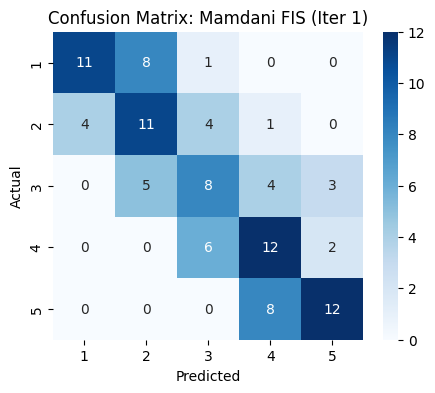


[Improved FIS] Testing...

--- Improved FIS (Iter 1) Results ---
              precision    recall  f1-score   support

           1       0.88      0.70      0.78        20
           2       0.65      0.75      0.70        20
           3       0.57      0.65      0.60        20
           4       0.44      0.60      0.51        20
           5       0.91      0.50      0.65        20

    accuracy                           0.64       100
   macro avg       0.69      0.64      0.65       100
weighted avg       0.69      0.64      0.65       100



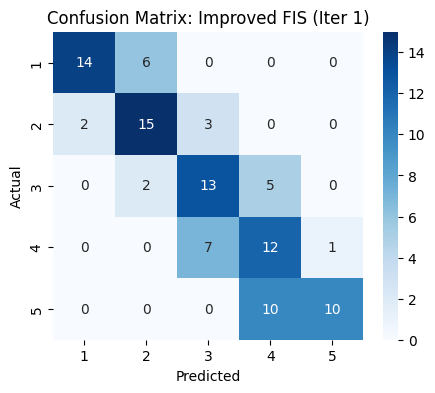


[ANFIS] Training and Testing...

--- ANFIS (Iter 1) Results ---
              precision    recall  f1-score   support

           1       0.92      0.88      0.90      2500
           2       0.81      0.84      0.83      2500
           3       0.86      0.83      0.84      2500
           4       0.82      0.83      0.83      2500
           5       0.89      0.92      0.90      2500

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



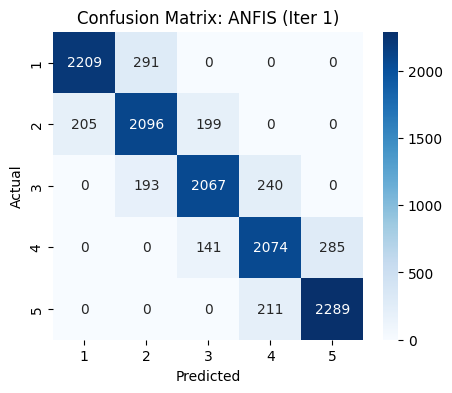



==================== EVALUATION ITERATION 2 ====================

[Mamdani FIS] Testing...

--- Mamdani FIS (Iter 2) Results ---
              precision    recall  f1-score   support

           1       0.69      0.45      0.55        20
           2       0.39      0.60      0.47        20
           3       0.50      0.55      0.52        20
           4       0.43      0.45      0.44        20
           5       0.85      0.55      0.67        20

    accuracy                           0.52       100
   macro avg       0.57      0.52      0.53       100
weighted avg       0.57      0.52      0.53       100



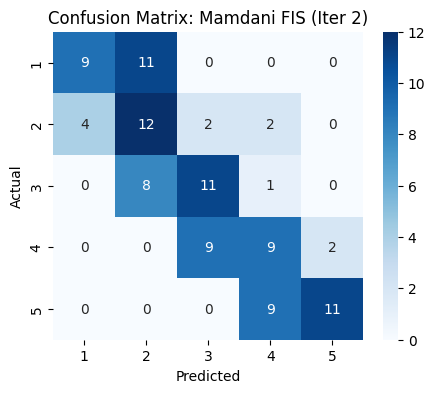


[Improved FIS] Testing...

--- Improved FIS (Iter 2) Results ---
              precision    recall  f1-score   support

           1       0.73      0.80      0.76        20
           2       0.43      0.50      0.47        20
           3       0.41      0.45      0.43        20
           4       0.52      0.60      0.56        20
           5       1.00      0.50      0.67        20

    accuracy                           0.57       100
   macro avg       0.62      0.57      0.58       100
weighted avg       0.62      0.57      0.58       100



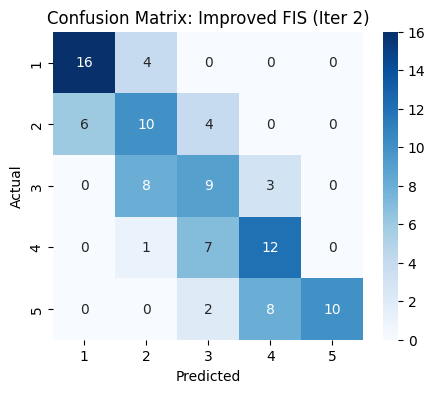


[ANFIS] Training and Testing...

--- ANFIS (Iter 2) Results ---
              precision    recall  f1-score   support

           1       0.91      0.89      0.90      2500
           2       0.80      0.86      0.83      2500
           3       0.87      0.84      0.85      2500
           4       0.83      0.83      0.83      2500
           5       0.90      0.90      0.90      2500

    accuracy                           0.86     12500
   macro avg       0.86      0.86      0.86     12500
weighted avg       0.86      0.86      0.86     12500



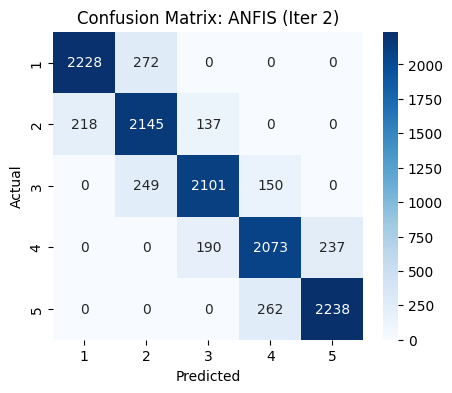


=== FINAL CROSS-MODEL EVALUATION REPORT ===
   Iter         Model     Acc      Prec     Rec        F1
0     1   Mamdani FIS  0.5400  0.559720  0.5400  0.544162
1     1  Improved FIS  0.6400  0.689185  0.6400  0.647181
2     1         ANFIS  0.8588  0.859378  0.8588  0.858890
3     2   Mamdani FIS  0.5200  0.570826  0.5200  0.529109
4     2  Improved FIS  0.5700  0.618577  0.5700  0.576080
5     2         ANFIS  0.8628  0.863844  0.8628  0.863086


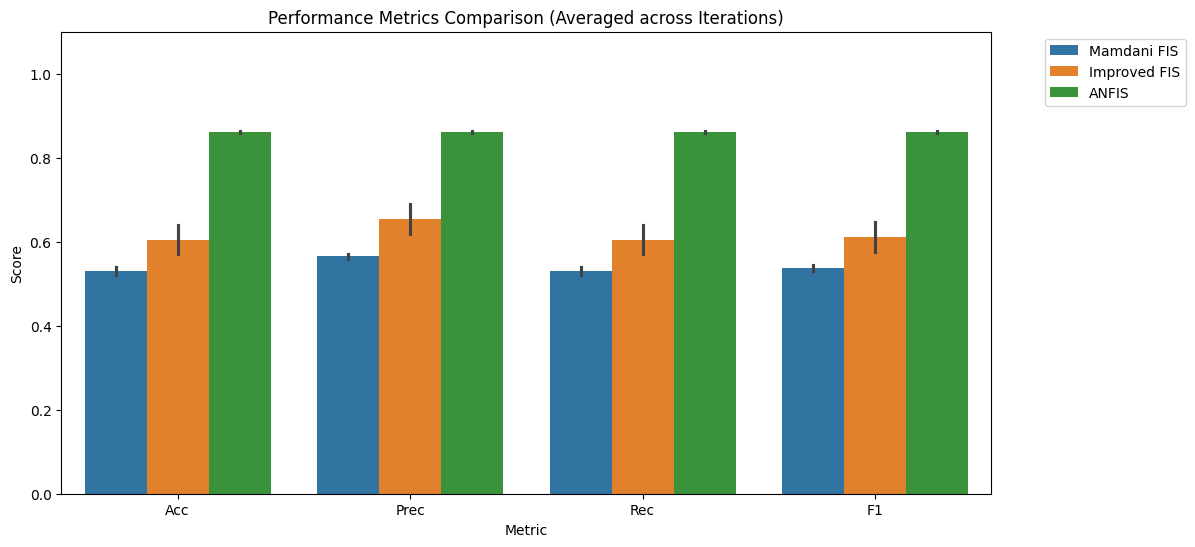


=== MEMBERSHIP FUNCTION VISUALIZATIONS (ALL INPUTS) ===


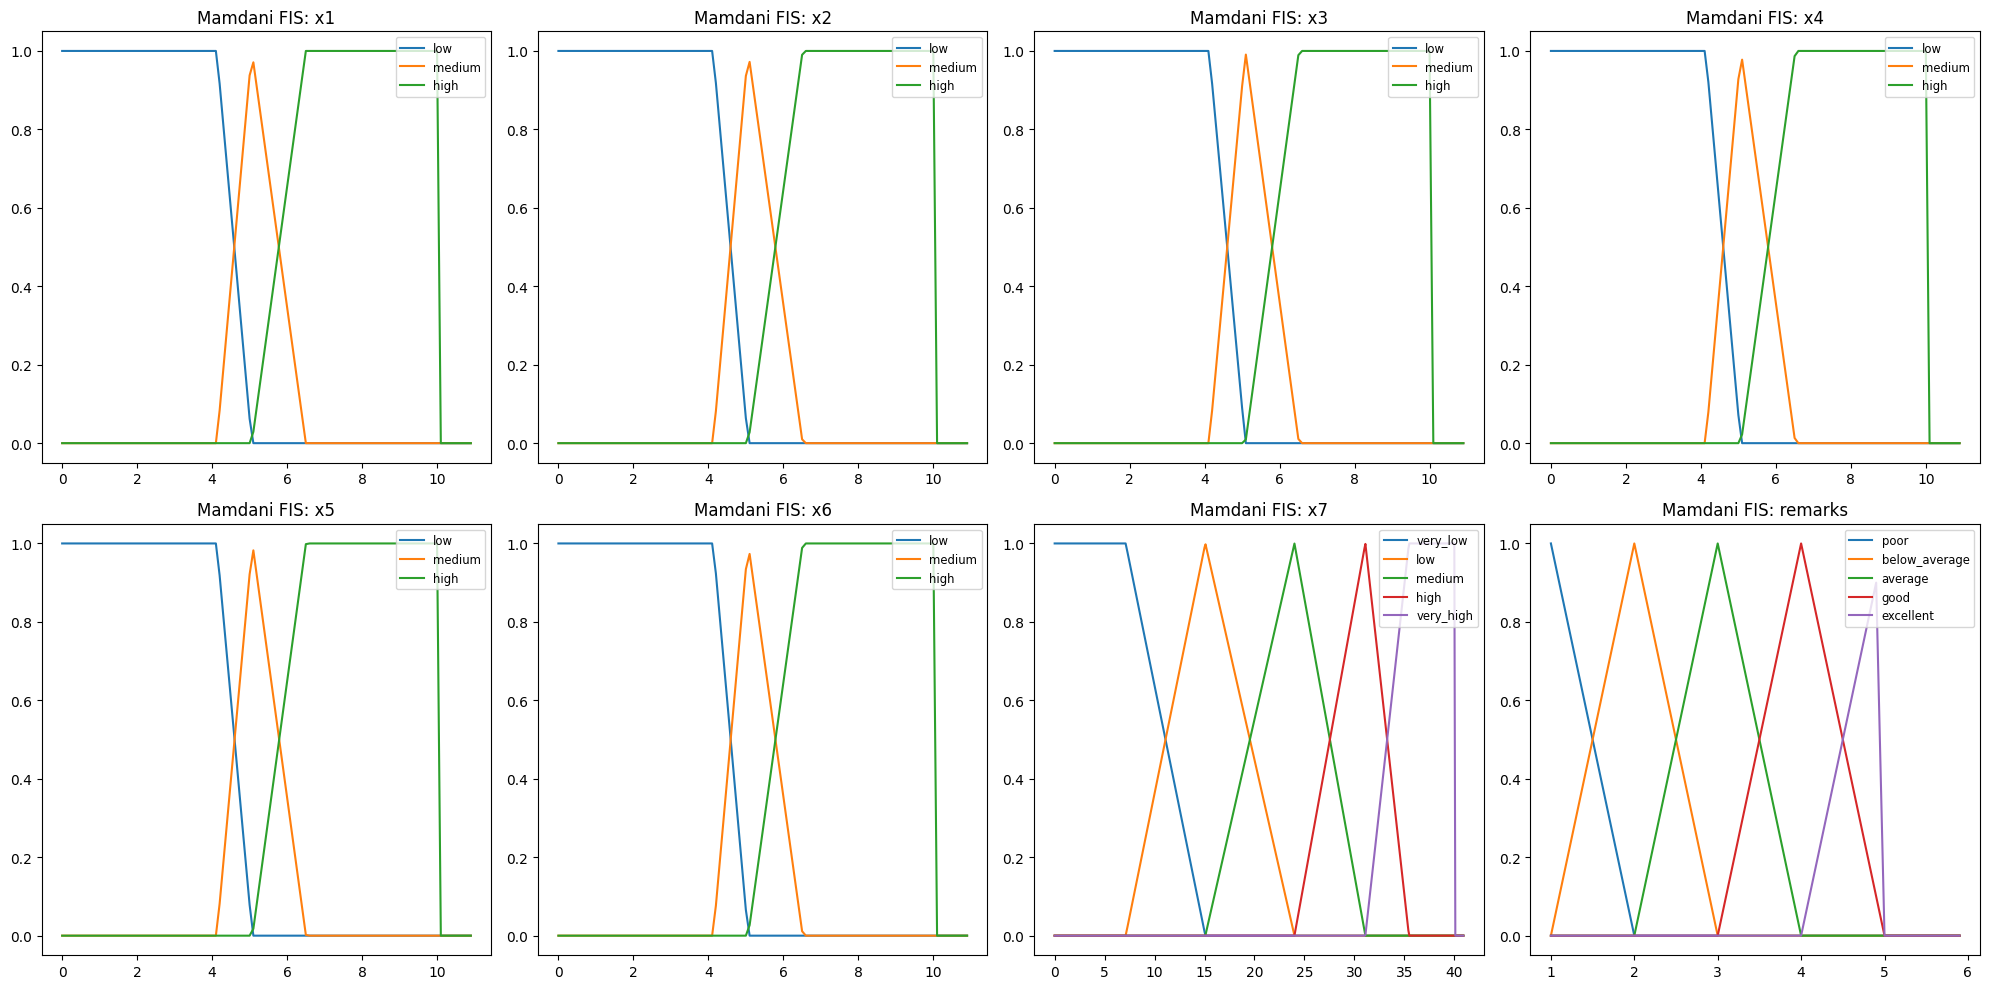

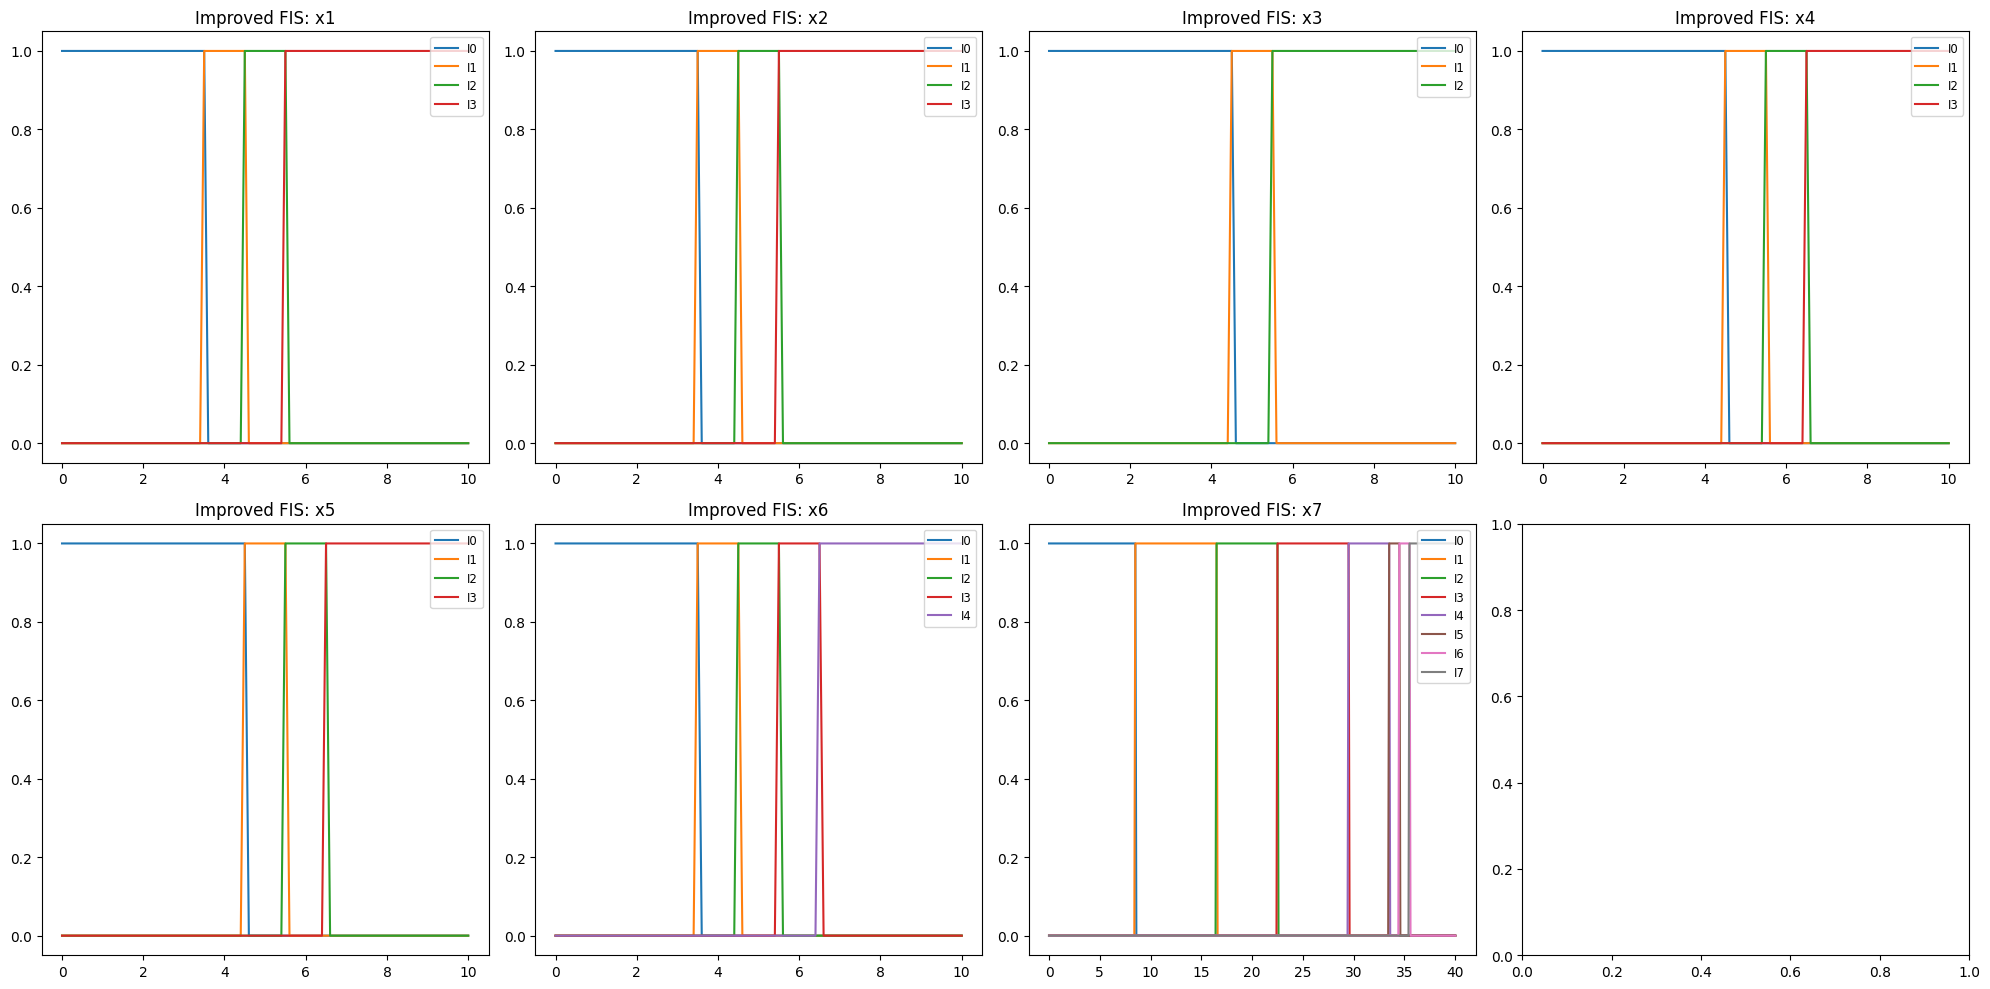

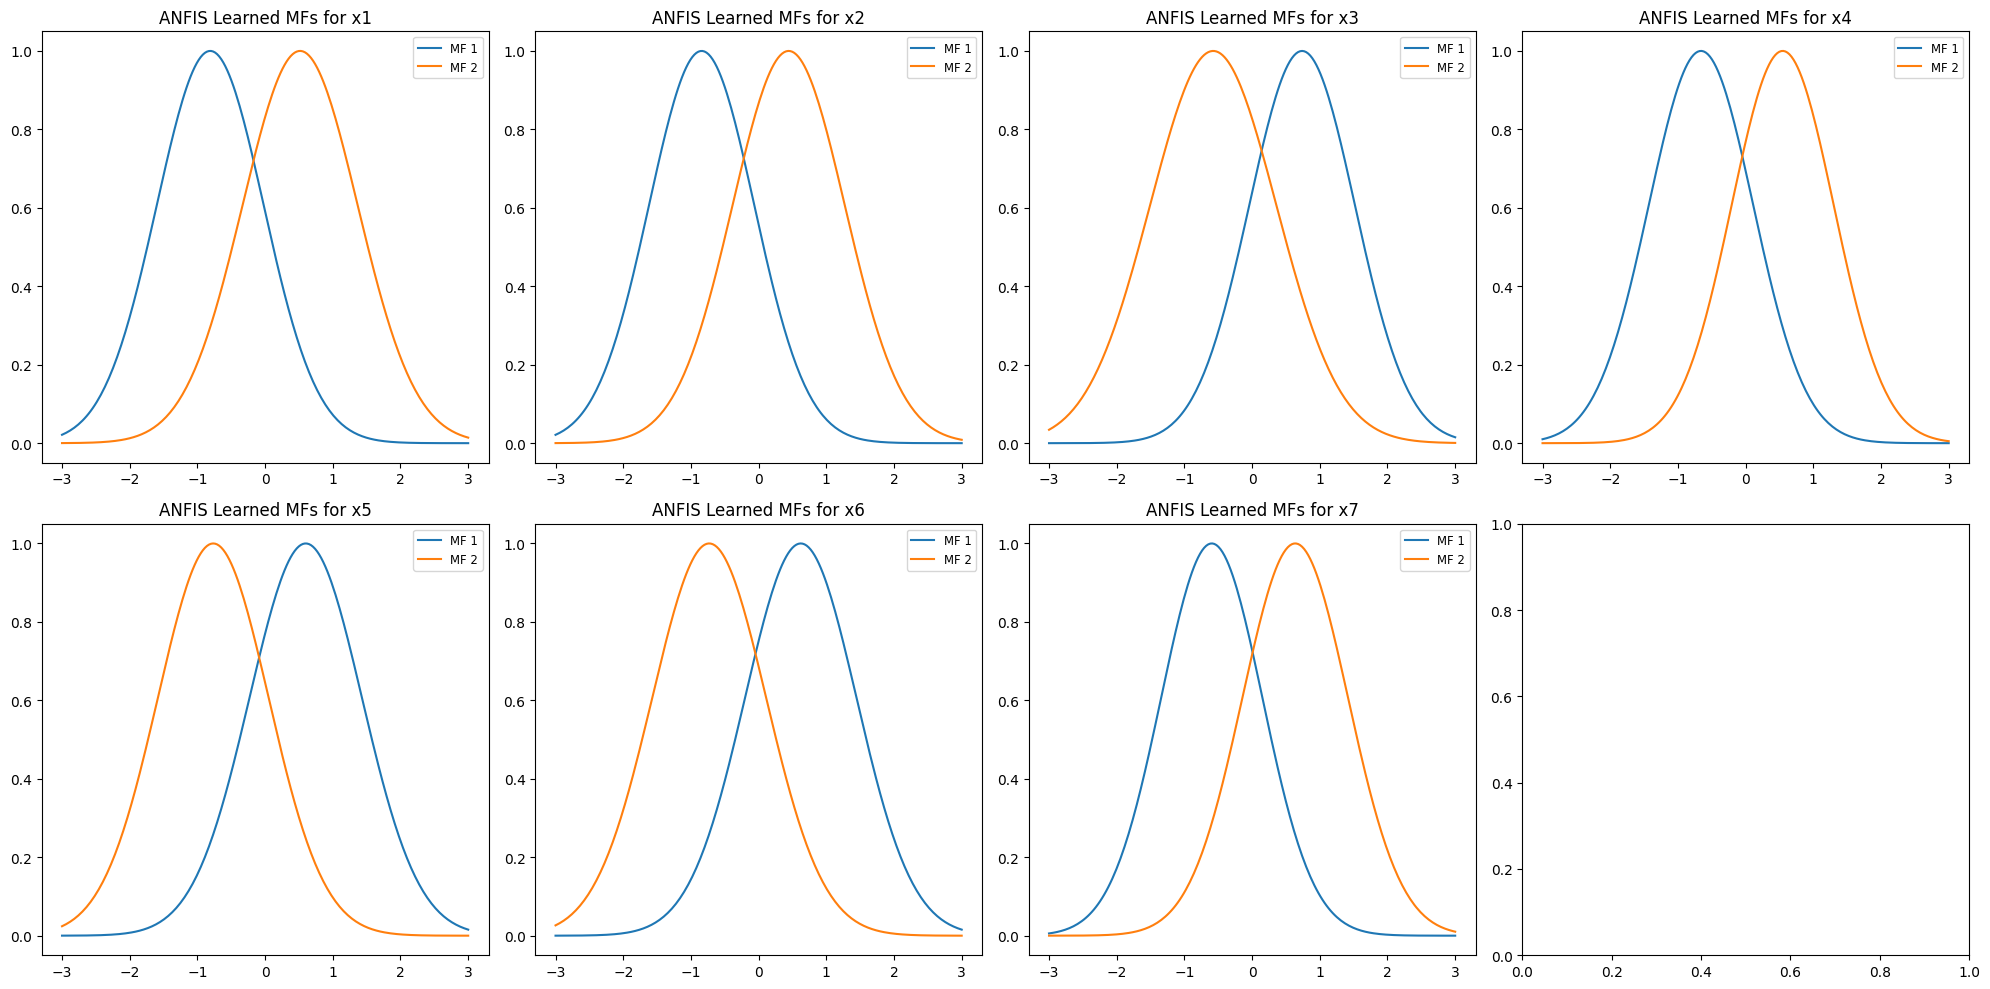

In [5]:

from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

def evaluate_models_iterations():
    from sklearn.metrics import recall_score, precision_score, f1_score
    all_metrics = []
    last_models = {}
    
    def show_detailed_results(y_true, y_pred, title="Model"):
        print(f"\n--- {title} Results ---")
        report = classification_report(y_true, y_pred, labels=[1, 2, 3, 4, 5], output_dict=True, zero_division=0)
        print(classification_report(y_true, y_pred, labels=[1, 2, 3, 4, 5], zero_division=0))
        
        cm = confusion_matrix(y_true, y_pred, labels=[1, 2, 3, 4, 5])
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
        plt.title(f'Confusion Matrix: {title}')
        plt.ylabel('Actual'); plt.xlabel('Predicted')
        plt.show()
        
        return report['weighted avg']

    # --- ONE-TIME: Extract Improved FIS Rules from WHOLE Dataset ---
    print("\n[Improved FIS] Extracting optimized rules from the entire dataset...")
    full_X = df[expected_cols[:-1]]
    full_y = df['remarks']
    opt_sim, opt_vars, _ = create_optimized_fis_dynamic(full_X, full_y)
    last_models['opt_vars'] = opt_vars

    for i in range(1, 3):
        print(f"\n\n{'='*20} EVALUATION ITERATION {i} {'='*20}")
        
        # 1. Samples (Per ReadMe: FIS 20/class, ANFIS 10,000/class)
        # Using the global seed to ensure reproducibility across runs
        parts_fis = [df[df['remarks'] == c].sample(20, random_state=RANDOM_SEED*i) for c in range(1, 6)]
        sample_fis = pd.concat(parts_fis).sample(frac=1, random_state=RANDOM_SEED*i)
        
        parts_anfis = [df[df['remarks'] == c].sample(10000, random_state=RANDOM_SEED*10*i) for c in range(1, 6)]
        sample_anfis = pd.concat(parts_anfis).sample(frac=1, random_state=RANDOM_SEED*10*i)

        # --- A. Mamdani FIS ---
        print("\n[Mamdani FIS] Testing...")
        y_m = get_fis_preds(manual_sim, sample_fis)
        m_res = show_detailed_results(sample_fis['remarks'], y_m, f"Mamdani FIS (Iter {i})")
        all_metrics.append({'Iter': i, 'Model': 'Mamdani FIS', 'Acc': accuracy_score(sample_fis['remarks'], y_m), 'Prec': m_res['precision'], 'Rec': m_res['recall'], 'F1': m_res['f1-score']})

        # --- B. Improved FIS ---
        print("\n[Improved FIS] Testing...")
        y_o = get_fis_preds(opt_sim, sample_fis)
        o_res = show_detailed_results(sample_fis['remarks'], y_o, f"Improved FIS (Iter {i})")
        all_metrics.append({'Iter': i, 'Model': 'Improved FIS', 'Acc': accuracy_score(sample_fis['remarks'], y_o), 'Prec': o_res['precision'], 'Rec': o_res['recall'], 'F1': o_res['f1-score']})

        # --- C. ANFIS ---
        print("\n[ANFIS] Training and Testing...")
        sc = StandardScaler()
        X_a = sc.fit_transform(sample_anfis[INPUTS].values)
        y_a = sample_anfis[TARGET].values - 1
        Xtr, Xte, ytr, yte = train_test_split(X_a, y_a, test_size=0.25, stratify=y_a, random_state=RANDOM_SEED)
        anf_model = run_anfis_one_seed(Xtr, Xte, ytr, yte, seed=RANDOM_SEED*i, epochs=150)[3]
        with torch.no_grad():
            preds = anf_model(torch.from_numpy(Xte).float().to(next(anf_model.parameters()).device)).argmax(1).cpu().numpy() + 1
        a_res = show_detailed_results(yte+1, preds, f"ANFIS (Iter {i})")
        all_metrics.append({'Iter': i, 'Model': 'ANFIS', 'Acc': accuracy_score(yte+1, preds), 'Prec': a_res['precision'], 'Rec': a_res['recall'], 'F1': a_res['f1-score']})
        last_models['anf'] = anf_model

    return pd.DataFrame(all_metrics), last_models

results_df, last_models = evaluate_models_iterations()
print("\n=== FINAL CROSS-MODEL EVALUATION REPORT ===")
print(results_df)

# Visualizing Comparisons
plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars=['Iter', 'Model'], value_vars=['Acc', 'Prec', 'Rec', 'F1'], var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Metric', y='Score', hue='Model')
plt.title('Performance Metrics Comparison (Averaged across Iterations)')
plt.ylim(0, 1.1); plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.show()

print("\n=== MEMBERSHIP FUNCTION VISUALIZATIONS (ALL INPUTS) ===")

def plot_all_mfs(vars_map, title_prefix):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for i, (name, var) in enumerate(vars_map.items()):
        if i >= 8: break
        for label in var.terms:
            axes[i].plot(var.universe, var[label].mf, label=label)
        axes[i].set_title(f"{title_prefix}: {name}")
        axes[i].legend(loc='upper right', fontsize='small')
    plt.tight_layout(); plt.show()

# 1. Mamdani
man_vars = {'x1':mx1, 'x2':mx2, 'x3':mx3, 'x4':mx4, 'x5':mx5, 'x6':mx6, 'x7':mx7, 'remarks':mremarks}
plot_all_mfs(man_vars, "Mamdani FIS")

# 2. Improved
if 'opt_vars' in last_models:
    plot_all_mfs(last_models['opt_vars'], "Improved FIS")

# 3. ANFIS
if 'anf' in last_models:
    with torch.no_grad():
        c = last_models['anf'].gauss.centers.cpu().numpy()
        s = torch.exp(last_models['anf'].gauss.log_sigmas).cpu().numpy()
    x = np.linspace(-3, 3, 200)
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    for d in range(7):
        for m in range(2):
            mu = np.exp(-0.5 * ((x - c[d, m]) / s[d, m])**2)
            axes[d].plot(x, mu, label=f'MF {m+1}')
        axes[d].set_title(f"ANFIS Learned MFs for x{d+1}")
        axes[d].legend(loc='upper right', fontsize='small')
    plt.tight_layout(); plt.show()


### ANFIS Neural Network Structure
The ANFIS model is implemented as a 5-layer neuro-fuzzy network:

```mermaid
graph LR
    input[Input Layer (x1...x7)] --> layer1[Layer 1: Fuzzification (Gaussian MFs)]
    layer1 --> layer2[Layer 2: Rule Firing Strength (Product T-Norm)]
    layer2 --> layer3[Layer 3: Normalization (w_norm)]
    layer3 --> layer4[Layer 4: Defuzzification (Weighted Consequent)]
    layer4 --> output[Output Layer (Grade Class)]
    
    style input fill:#f9f,stroke:#333
    style layer1 fill:#bbf,stroke:#333
    style layer4 fill:#bfb,stroke:#333
```

**Structure Details:**
- **Input**: 7 Features (Standard Scaled)
- **Layer 1**: 2 Gaussian Membership Functions per input ($M=2, D=7$) learnable parameters ($\mu, \sigma$).
- **Layer 2**: Computes firing strength $w_i = \prod \mu_{ij}$ for all rules.
- **Layer 3**: Normalizes strengths $\bar{w}_i = w_i / \sum w_j$.
- **Layer 4**: Takagi-Sugeno Zero-Order consequents (learnable weights).
- **Output**: Summation $\sum \bar{w}_i f_i$.
